In [21]:
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions import UnitaryGate
import numpy as np

In [2]:
def logicalAnd(circuit,input_qubits,output_qubit):
    circuit.mcx(input_qubits,output_qubit)
    
def logicalOr(circuit,input_qubits,output_qubit):
    for i in input_qubits:
        circuit.x(i)
    circuit.x(output_qubit)
    circuit.mcx(input_qubits,output_qubit)
    for i in input_qubits:
        circuit.x(i)

In [17]:
def CNF(maxterms):
    n = len(maxterms[0])
    m = len(maxterms)
    circuit = QuantumCircuit(n+m+1)
    o = n
    for t in maxterms:
        inp = []
        for i in range(0,n):
            if t[i] == -1:
                circuit.x(i)
                inp.append(i)
            elif t[i] == 1:
                inp.append(i)
        logicalOr(circuit,inp,o)
        for i in range(0,n):
            if t[i] == -1:
                circuit.x(i)
        o = o+1
    logicalAnd(circuit,list(range(n,n+m)),n+m)
    return circuit.to_gate()

def diffusion(n):
    m = np.identity(2**n)
    for i in range(1,2**n):
        m[i][i] = -1
    return UnitaryGate(m)

## Grover's algorithm applied to the SAT problem

In [47]:
def grover(maxterms,rounds = 0):
    n = len(maxterms[0]) #number of variables
    N = 2**n #solution space size
    m = len(maxterms) #number of maxterms
    if rounds == 0:
        r = int(np.ceil(np.pi/(4*np.arcsin(1/np.sqrt(N)))-0.5))
    else:
        r = rounds
    circuit = QuantumCircuit(n+m+1,n)
    circuit.x(n+m)
    circuit.h(n+m)
    for i in range(n):
        circuit.h(i)
    cnf = CNF(maxterms)
    cnf.label = 'Uf'
    diff = diffusion(n)
    diff.label = 'Diff'
    for i in range(r):
        circuit.append(cnf,range(n+m+1))
        for i in range(n,n+m):
            circuit.reset(i)
        for i in range(n):
            circuit.h(i)
        circuit.append(diff,range(n))
        for i in range(n):
            circuit.h(i)
    for i in range(n):
        circuit.measure(i,i)
    return circuit

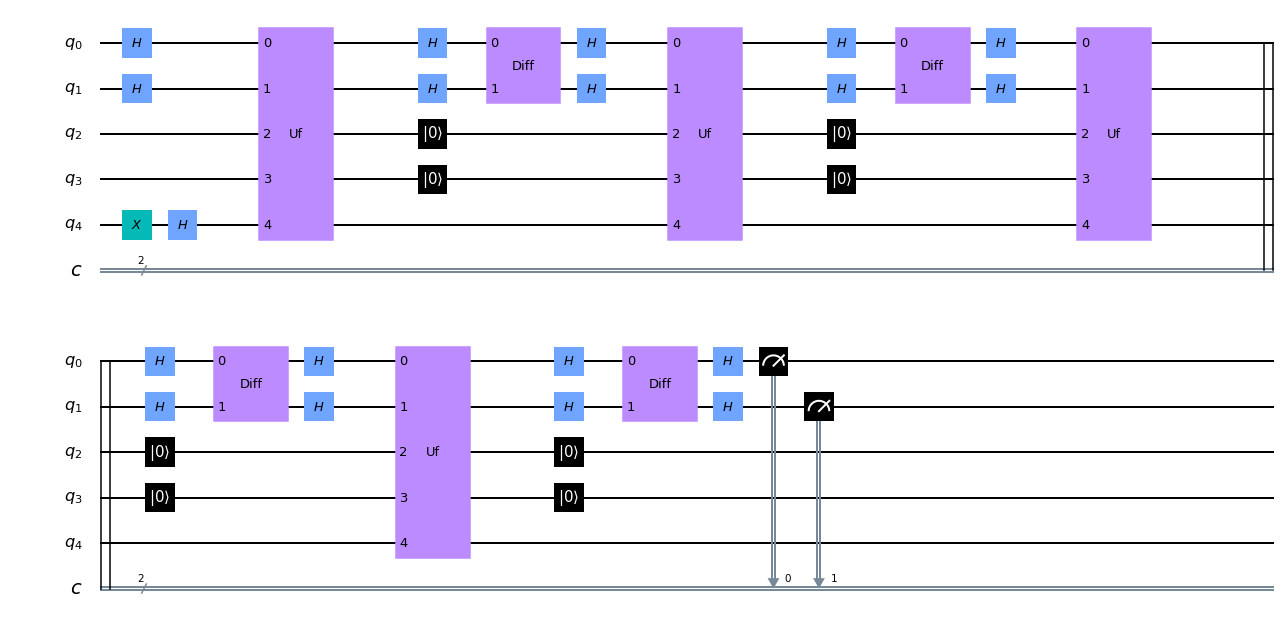

In [65]:
maxterms = [[1,-1],[-1,1]] # f(x,y) = xy' + x'y
circuit = grover(maxterms,4)
#circuit = grover(maxterms)
circuit.draw('mpl')

{'11': 167, '01': 330, '00': 168, '10': 335}


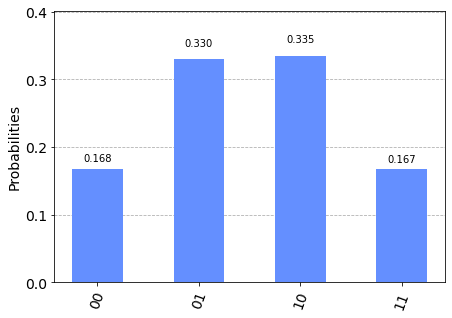

In [67]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, simulator, shots=1000).result()
counts = result.get_counts(circuit)
print(counts)
plot_histogram(counts)